## Assignment 1 - Classification


## Learning Outcomes


* Data exploration and pre-processing

* Develop a pipeline to carry out classification

* Compare different metrics and classifiers

The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using grid search.


In [1]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


**Questions (12 marks total)**

Q1.  Explore the credit card data set provided. You can also access it from the this link 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
(https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

The data is open for public use and no authorizations are required.

You will build a classification model for this default of credit card clients dataset.  The objective is to predict whether or not a credit card client will default for their payment in the next month.

Make sure you perform your analyses and answer the questions in sections below:

1. Data exploration:  ( 3 marks) 

    - Explore the data ( for example look at the data, plot graphs ( histogram, pair plots)
    
2. Data Preprocessing: (4 marks)

    - Make sure you build a full data pipeline ( ie., use the pipeline to apply transformers and estimators- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html )
    - Do you require any data pre-processing? Are all the features useful? (Use only raw features from this dataset, in other words, no need to create feature crosses or new features)
    - Set the random seed to 123 (For splitting or any other random algorithm)
    - Split data into training (80%) and testing (20%)
    - Use Cross-validation with 5-folds
    - For other parameters, use default

3. Classification: (5 marks)

    - Study the ROC Curve, decide threshold
    - Use 2 classifiers.
    
         a. Random Forest
            - tune only: n_estimators: {4, 5, 10, 20, 50}.  We will be running random forest model using GridSearchCV, determine the best hyperparameter for the given list of n_estimators {4, 5, 10, 20, 50}. n_estimators refers to the number of trees in the forest. We will use CV = 5 and the scoring to be the roc_auc (area under the curve)
          
       b. KNN Classfier 
            - tune only: n_neighbors: {3, 5, 10, 20}. You may perform similar GridSearchCV as in the previous exercise with a given list of n_neightbors. 
        
    - Which one performs better in the cross validation? Note down your observations and give comments.
    
You may refer to the documentation for RandomForests and KNN Classifiers, for the different parameters and options available in the scikit-learn library.
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



In [2]:
### Your code here

## Feel free to use multiple cells  and continue from here:

df = pd.read_excel("./default of credit card clients.xls", sheet_name = 0, skiprows= 1, header = 0)

### Data exploration

In [3]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

We have 30,000 entries, and 25 columns.
We don't have null columns.
All the variables are int64 type, but not all the variables are numerical, a lot of them are categorical.

Below I define de different types of variables.

In [5]:
dep_var = ['default payment next month']

continuous_vars = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

discrete_vars = ['AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

categorical_vars = ['SEX', 'EDUCATION', 'MARRIAGE']

#### Dependant variable

<AxesSubplot:xlabel='default payment next month'>

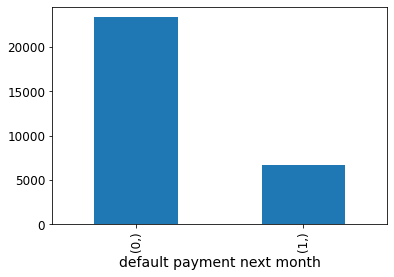

In [7]:
df[dep_var].value_counts().plot.bar()

In the plot we can see that there's more zero labeled observations than ones. This means the data is unbalanced, which will affect the selection for our performing metric.

#### Numerical variables

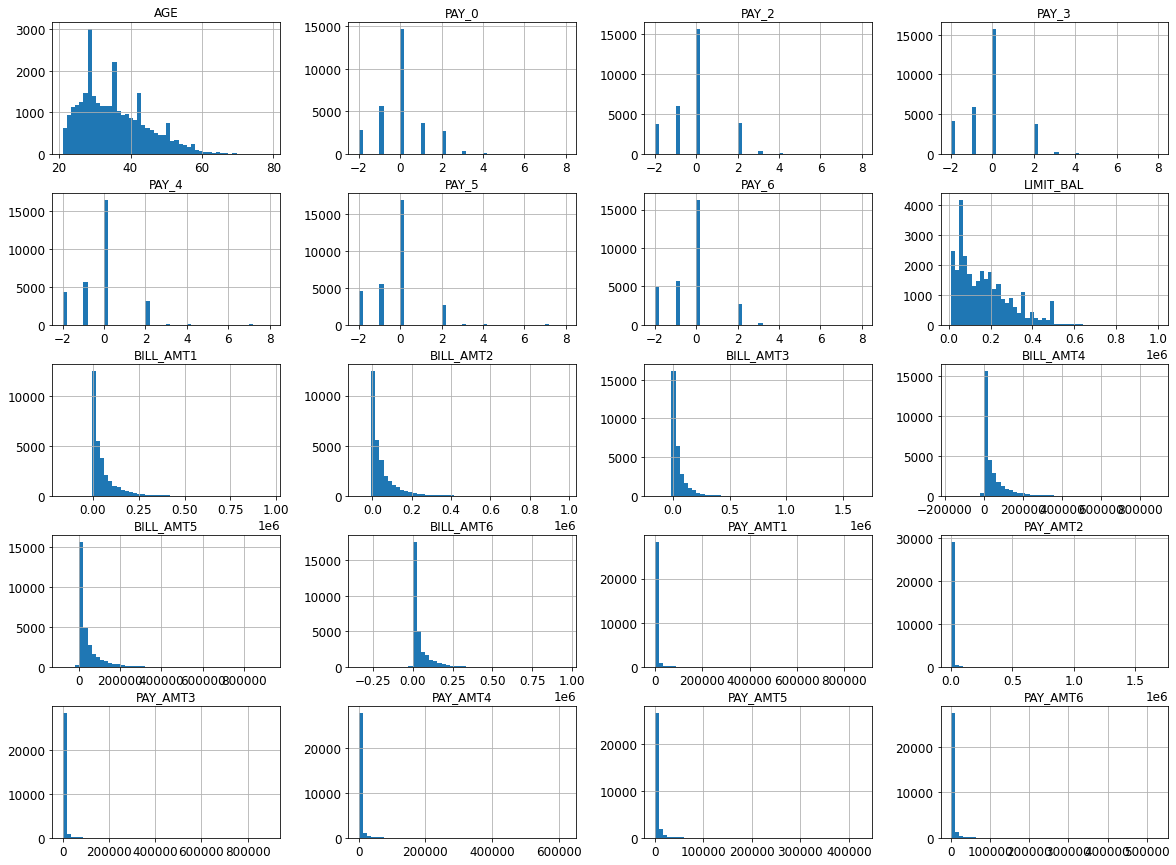

In [35]:
df.loc[:, discrete_vars + continuous_vars].hist(bins=50, figsize=(20,15))
plt.show()

We can log transform the Bill Amount and Pay Amount variables. As some amounts are close to zero, we can add 1 to avoid transformations lower than zero.

In [12]:
df['L_BILL_AMT1'] = (df['BILL_AMT1']+1).apply(np.log)
df['L_BILL_AMT2'] = (df['BILL_AMT2']+1).apply(np.log)
df['L_BILL_AMT3'] = (df['BILL_AMT3']+1).apply(np.log)
df['L_BILL_AMT4'] = (df['BILL_AMT4']+1).apply(np.log)
df['L_BILL_AMT5'] = (df['BILL_AMT5']+1).apply(np.log)
df['L_BILL_AMT6'] = (df['BILL_AMT6']+1).apply(np.log)
df['L_PAY_AMT1'] = (df['PAY_AMT1']+1).apply(np.log)
df['L_PAY_AMT2'] = (df['PAY_AMT2']+1).apply(np.log)
df['L_PAY_AMT3'] = (df['PAY_AMT3']+1).apply(np.log)
df['L_PAY_AMT4'] = (df['PAY_AMT4']+1).apply(np.log)
df['L_PAY_AMT5'] = (df['PAY_AMT5']+1).apply(np.log)
df['L_PAY_AMT6'] = (df['PAY_AMT6']+1).apply(np.log)

In [13]:
continuous_vars_log = ['LIMIT_BAL', 'L_BILL_AMT1', 'L_BILL_AMT2', 'L_BILL_AMT3', 'L_BILL_AMT4', 'L_BILL_AMT5',
                       'L_BILL_AMT6', 'L_PAY_AMT1', 'L_PAY_AMT2', 'L_PAY_AMT3', 'L_PAY_AMT4', 'L_PAY_AMT5', 'L_PAY_AMT6']

LIMIT_BAL


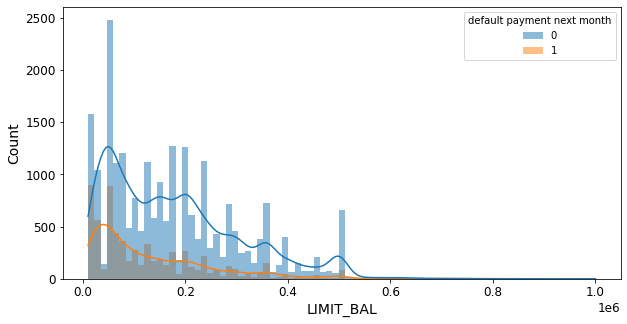

L_BILL_AMT1


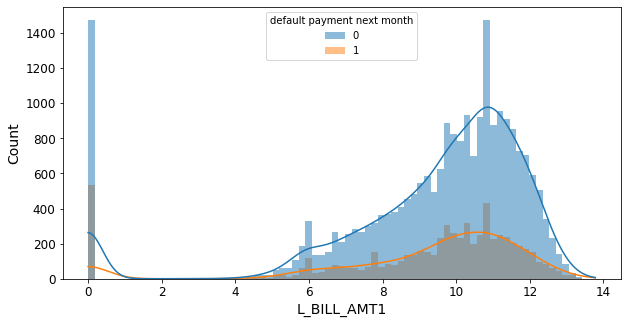

L_BILL_AMT2


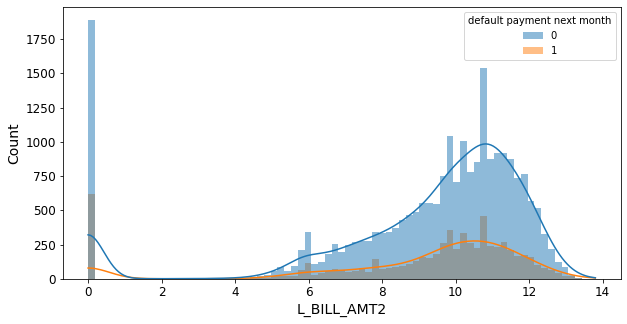

L_BILL_AMT3


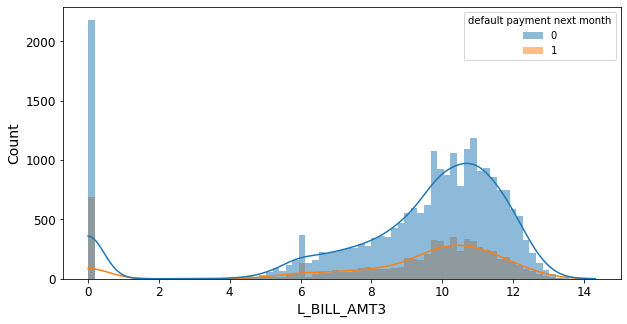

L_BILL_AMT4


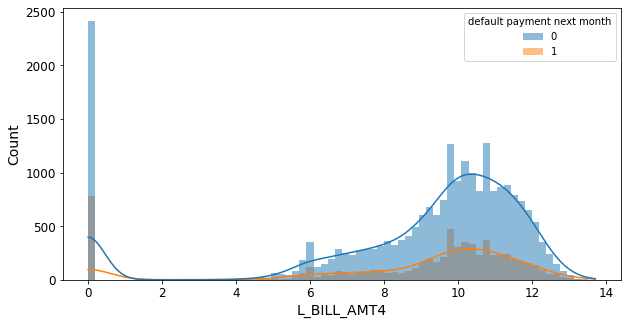

L_BILL_AMT5


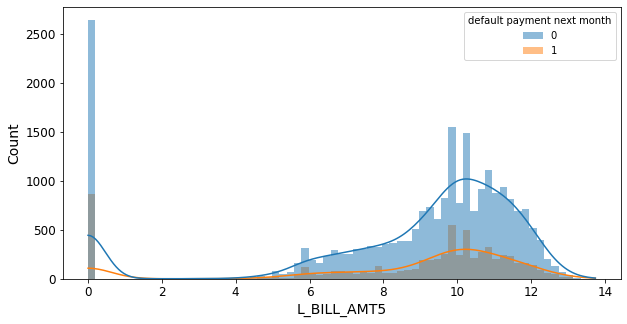

L_BILL_AMT6


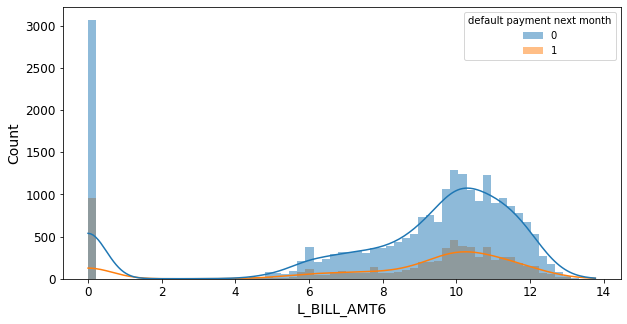

L_PAY_AMT1


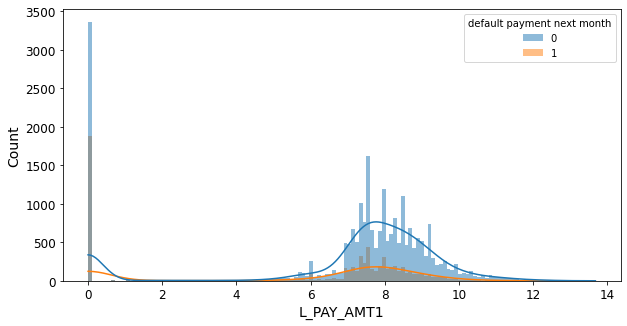

L_PAY_AMT2


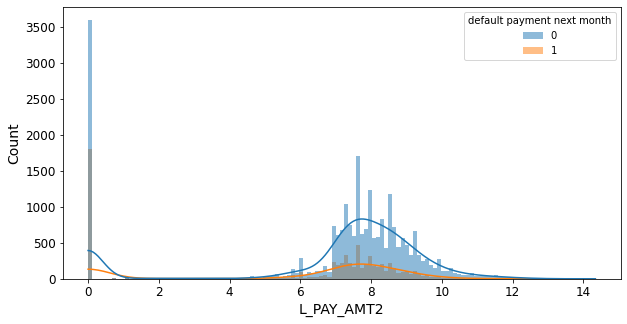

L_PAY_AMT3


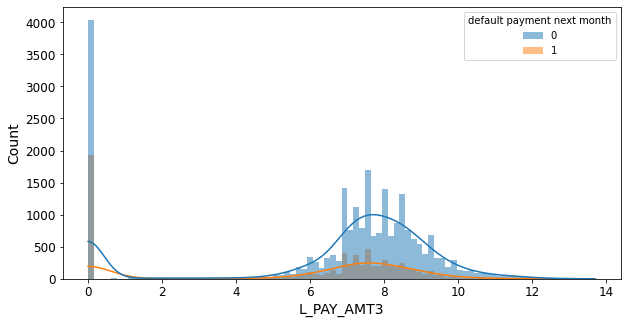

L_PAY_AMT4


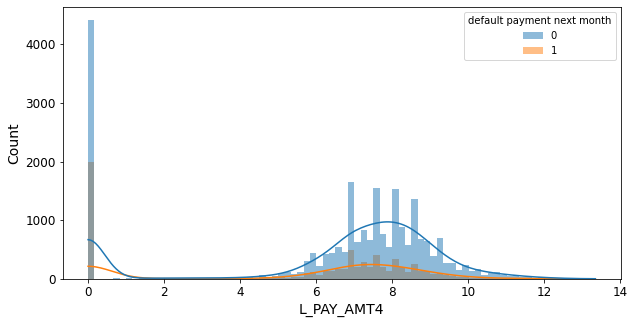

L_PAY_AMT5


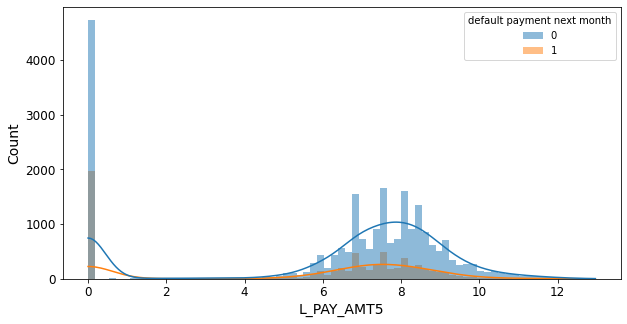

L_PAY_AMT6


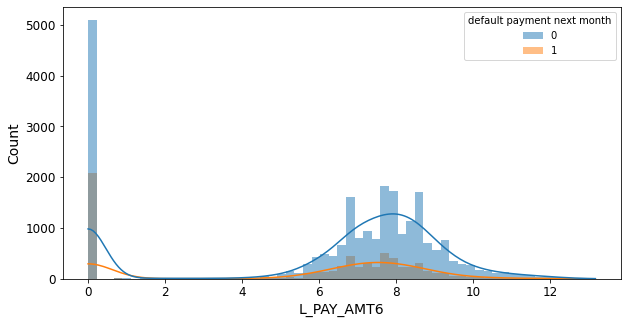

AGE


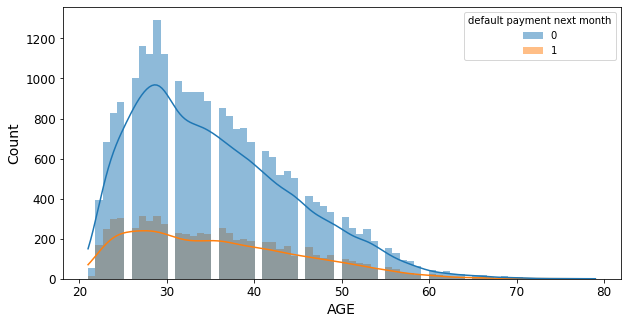

PAY_0


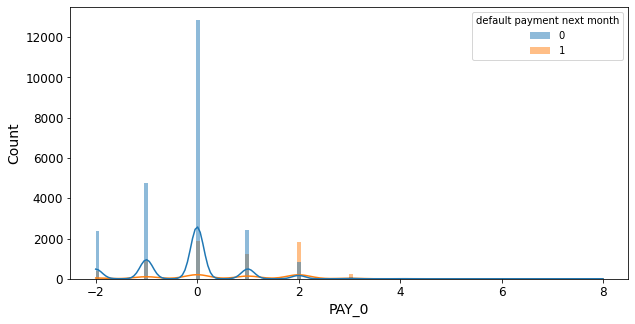

PAY_2


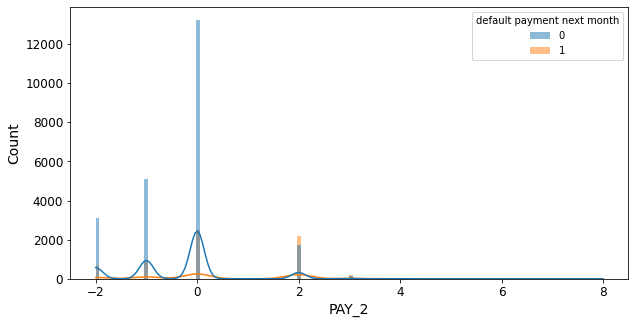

PAY_3


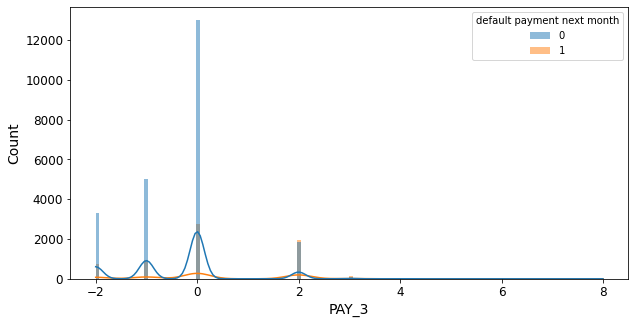

PAY_4


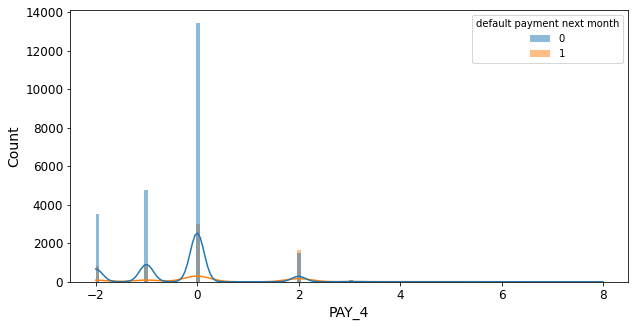

PAY_5


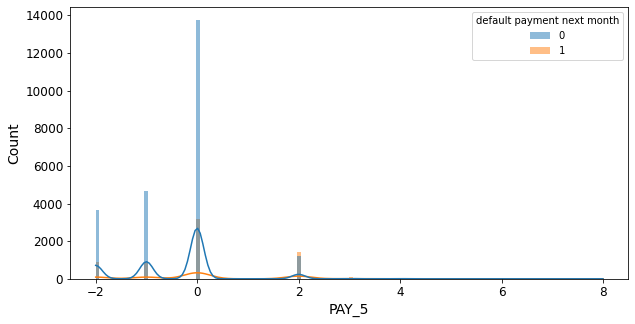

PAY_6


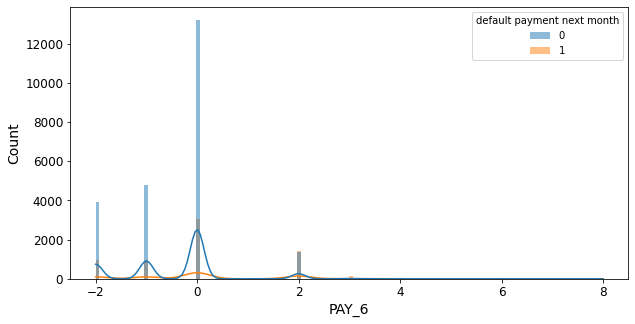

In [14]:
for v in (continuous_vars_log+discrete_vars):
    print(v)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df[[v] + dep_var], x=v, hue=dep_var[0], lw=0, kde=True, ax=ax)
    plt.show()


#### Categorical variables

SEX


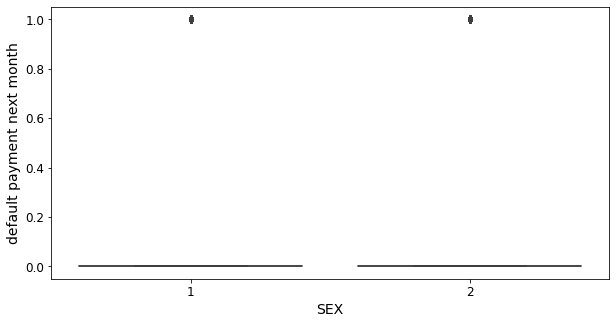

EDUCATION


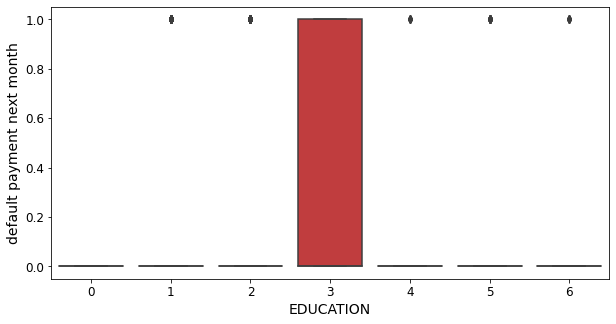

MARRIAGE


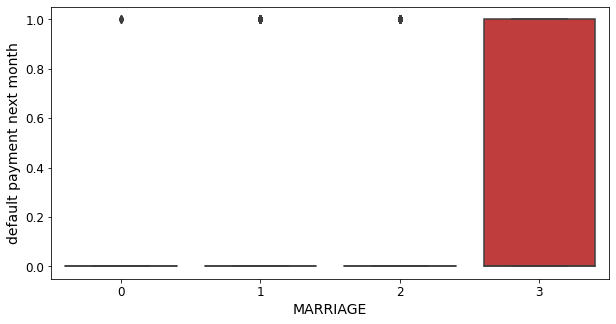

In [46]:
for v in categorical_vars:
    print(v)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(data=df[[v]+dep_var], x=v, y=dep_var[0], ax=ax)
    plt.show()


###  Data Preprocessing

There's no need for imputation, but we need to one hot encode the categorical variables and scale the data.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [7]:
# Categorical - impute, one hot encode
cat_ohe_step = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Numerical - impute, scale
num_scl_step = MinMaxScaler()

In [8]:
ct = ColumnTransformer([
    ('cat', cat_ohe_step, categorical_vars),
    ('num', num_scl_step, discrete_vars + continuous_vars)
])
ct.fit(df[categorical_vars + discrete_vars + continuous_vars])
X = ct.transform(df[categorical_vars + discrete_vars + continuous_vars])

y = df[dep_var].values

#### Train test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Conclusions

Explain your results and choices